In [1]:
import pandas as pd
import numpy as np
import datetime

dfs = []
# Data is split into 79 files, modify the range if you don't want to use all files.
for i in range(0,4):
    if i < 10:
        i = f"0{i}"
    df = pd.read_csv(f"data/2022_place_canvas_history-0000000000{i}.csv.gzip", compression="gzip")
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,timestamp,user_id,pixel_color,coordinate
0,2022-04-04 00:53:51.577 UTC,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,"826,1048"
1,2022-04-04 00:53:53.758 UTC,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,"583,1031"
2,2022-04-04 00:53:54.685 UTC,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,"1873,558"
3,2022-04-04 00:54:57.541 UTC,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,"1627,255"
4,2022-04-04 00:55:16.307 UTC,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,"49,1478"


Pandas have a built-in data parser but in my experience, it is super slow (in this example it was about 7 times slower).

In [2]:
def parse_date(date):
    try:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S')

df['timestamp'] = df['timestamp'].apply(lambda x: parse_date(x))

Those cells are split to easily see the **runtime** of the **data parser**.

In [3]:
df['user_id'] = df['user_id'].astype('string')
df['pixel_color'] = df['pixel_color'].astype('string')

def parse_cord(cord):
    try:
        return float(cord.replace(",", "."))
    except ValueError:
        # Mods sometimes used the rectangle tool to censor NSFW, in those cases cords look like this (x1,y1,x2,y2).
        # With the code below we can get a tuple with opposite rectangle corners, but I didn't need that data.
        ###
        # cords = cord.split('.')
        # return (float(cord[0]+'.'+cord[1]), float(cord[2]+'.'+cord[3]))
        ###
        return np.NaN


df["coordinate"] = df["coordinate"].apply(lambda x: parse_cord(x))

df.dropna(how="any", inplace=True)
df.dtypes

timestamp      datetime64[ns]
user_id                string
pixel_color            string
coordinate            float64
dtype: object

### Prepare matplotlib
Each analysis will be split into three parts:
1. Description
2. Data editing
3. Ploting

In [4]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
figsize = (20, 10)

#### Pixels per color
We are getting **number of pixels** placed depending on **color** of the **pixel**.

In [5]:
colors = df["pixel_color"].value_counts().rename_axis('pixel_color').to_frame('counts').reset_index()
colors.head()

,pixel_color,counts
0,#000000,1405817
1,#FFFFFF,1041600
2,#2450A4,460580
3,#BE0039,402055
4,#FFA800,389683


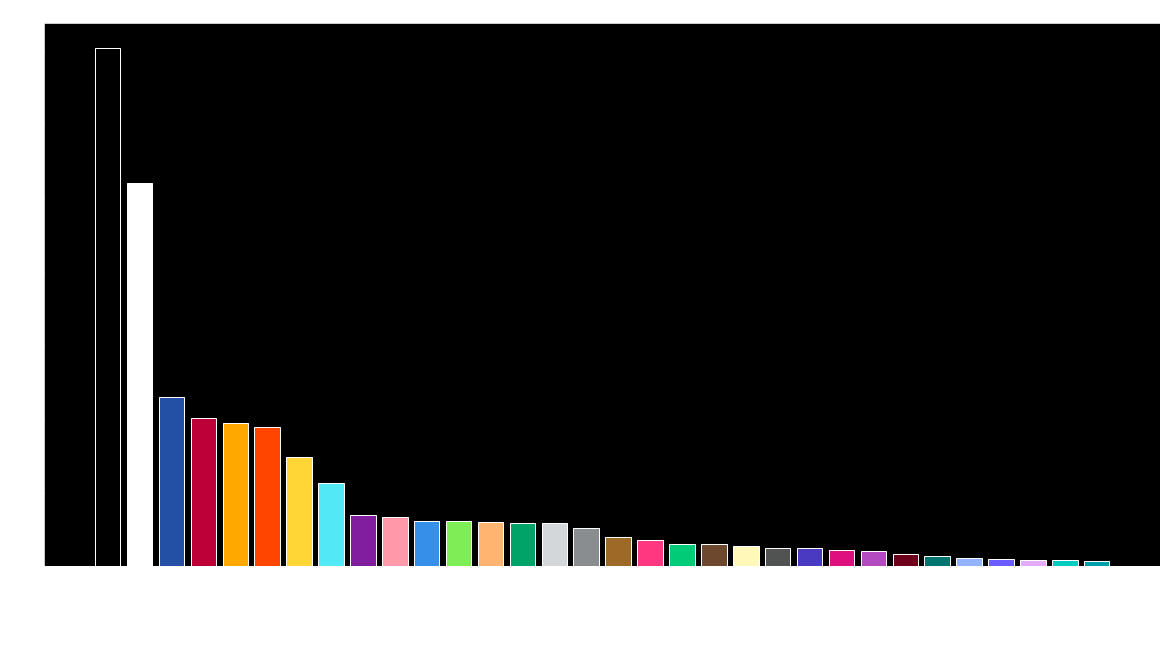

In [6]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(colors["pixel_color"], colors["counts"], color=colors["pixel_color"], edgecolor="#FFFFFF")
ax.set_title('Pixels placed per color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_counts.pdf')

#### Max pixels placed per user based on color
Same thing as above but we are getting **maximum** number of **pixels** placed by **one user** based on **color**.

In [28]:
colors = df.iloc[:, 1:3]
colors['count'] = 1
colors= pd.pivot_table(colors, values='count', index='user_id', columns='pixel_color', aggfunc='count')

color_user = pd.DataFrame(columns=["pixel_color", "user_max"])
for name, column in colors.items():
    temp = pd.DataFrame({"pixel_color": [name], "user_max": [column.max()]})
    color_user = pd.concat([color_user, temp], ignore_index = True)
color_user.sort_values(by='user_max', ascending = False, inplace=True)


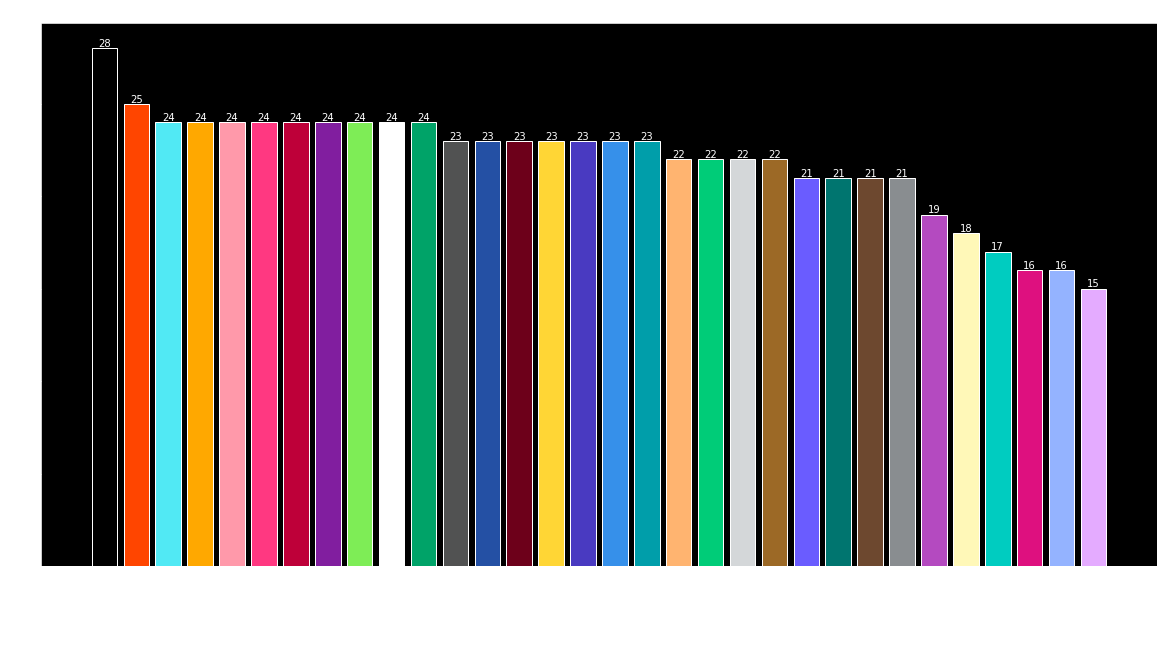

In [29]:
fig, ax = plt.subplots(figsize=figsize)
bars = ax.bar(color_user["pixel_color"], color_user["user_max"], color=color_user["pixel_color"], edgecolor="#FFFFFF")
ax.bar_label(bars)
ax.set_title('Max pixels placed per one user based on color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_user_counts.pdf')

#### Distribution of people who placed *x* many pixels.

In [9]:
pix_usr = df["user_id"].value_counts().to_frame('pixels').reset_index(drop=True)
# We will use pix_usr later on
pix_usr_count = pix_usr["pixels"].value_counts().rename_axis('pixels').to_frame('howmany')
pix_usr_count.head()

,howmany
pixels,
1,607153
2,268958
3,158363
4,108536
5,82738


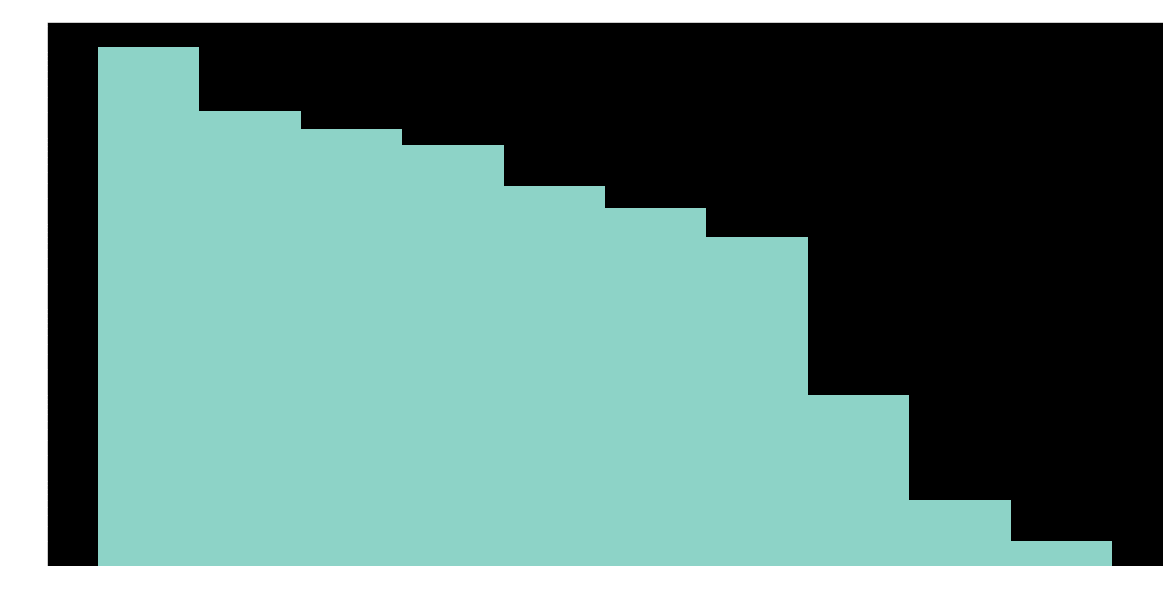

In [10]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_yscale('log')
ax.set_ylabel('user count')
ax.set_xlabel('tiles placed')
ax.set_title('Number of users who placed x many pixels')
ax.hist(pix_usr['pixels'])
fig.savefig("./plots/tiles_per_user.pdf")

#### Top 10 users with maximum pixels placed

In [11]:
pix_usr = pix_usr[:10]
pix_usr.index += 1

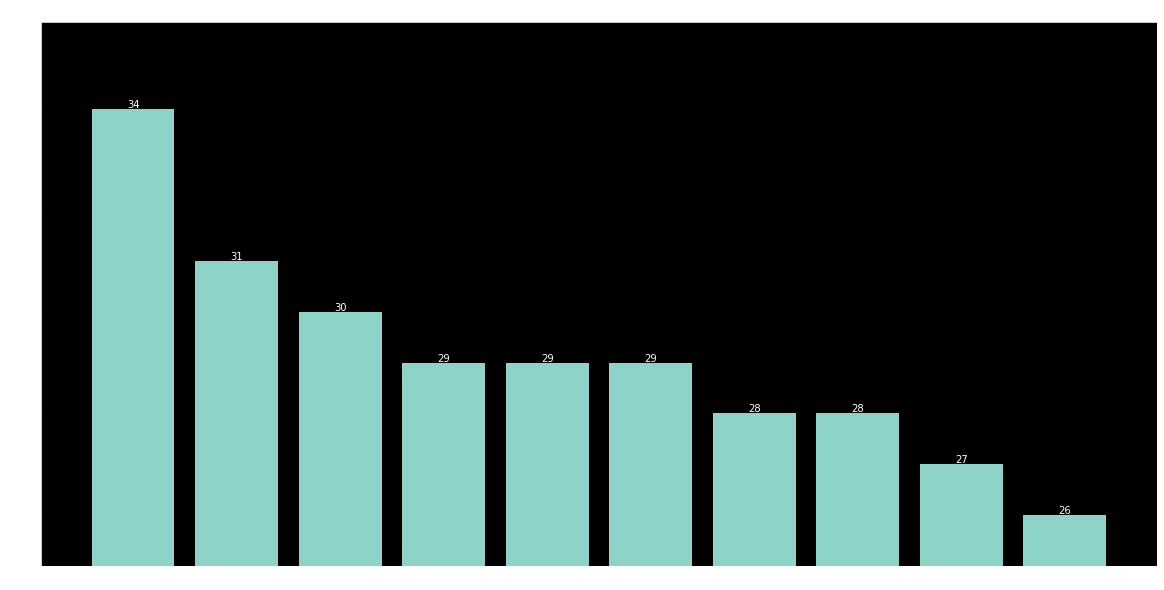

In [12]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel('tiles placed')
ax.set_title('Pixels placed per user [Top 10]')
bars = ax.bar(['#'+str(i) for i in pix_usr.index], pix_usr['pixels'])
ax.bar_label(bars)
ax.set_ylim(ymin=min(pix_usr['pixels']-1))
fig.savefig('./plots/top10_tiles_per_user.pdf')

#### Heatmap of pixels
really sketchy but i spend like 7 hours on this plot

In [13]:
def parse_cords(cord: float):
    cord = str(cord).split(".")
    h_map[int(cord[0])][int(cord[1])] += 1

In [14]:
# Creating an array of pixel occurrences
h_map = np.zeros((2000, 2000), dtype='int')
cords = df["coordinate"].map(lambda cord: parse_cords(cord))
print(h_map)

[[2103  271  114 ...   25   84  980]
 [ 283  296   51 ...   99  227   94]
 [ 105   34  101 ...  122  131   25]
 ...
 [  47   41   23 ...   21   29   88]
 [ 100   69   32 ...   29  112  272]
 [ 916   83   36 ...   56  186 1831]]


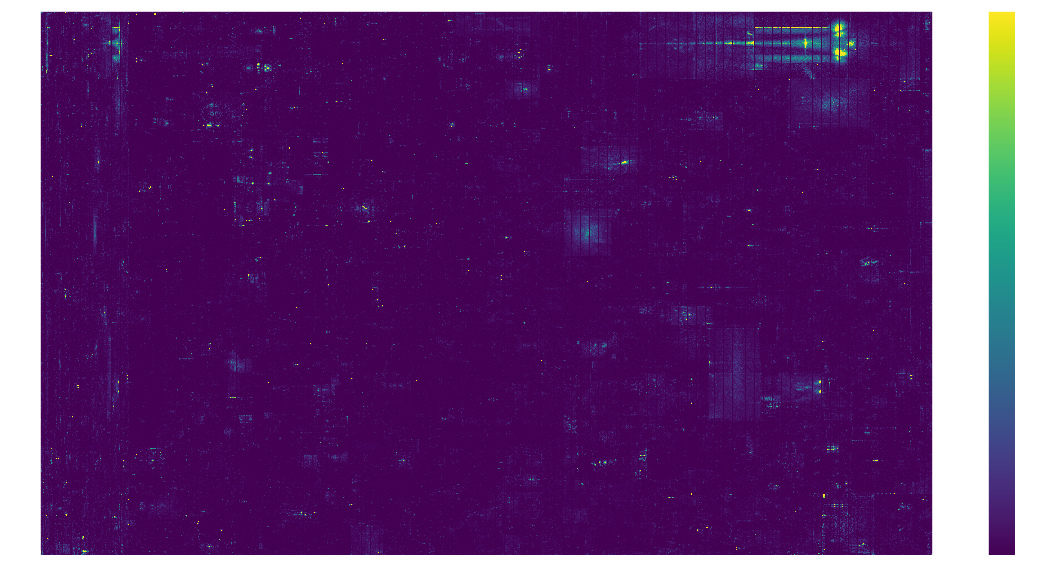

In [15]:
fig, ax = plt.subplots(figsize=figsize)
ax = plt.imshow(h_map, interpolation='none', aspect='auto', vmax = 100)
plt.colorbar()
fig.savefig('./plots/pixels_heatmap.pdf')

#### Activity based on time of the day
How many **pixels** were **placed** based on **hour** of the day [UTC].

In [16]:
hourly = df["timestamp"].dt.strftime('%H')
hourly = hourly.value_counts().rename_axis("hour").to_frame("counts").sort_index()
hourly

,counts
hour,
00,575806
01,2069268
22,74840
23,3517121


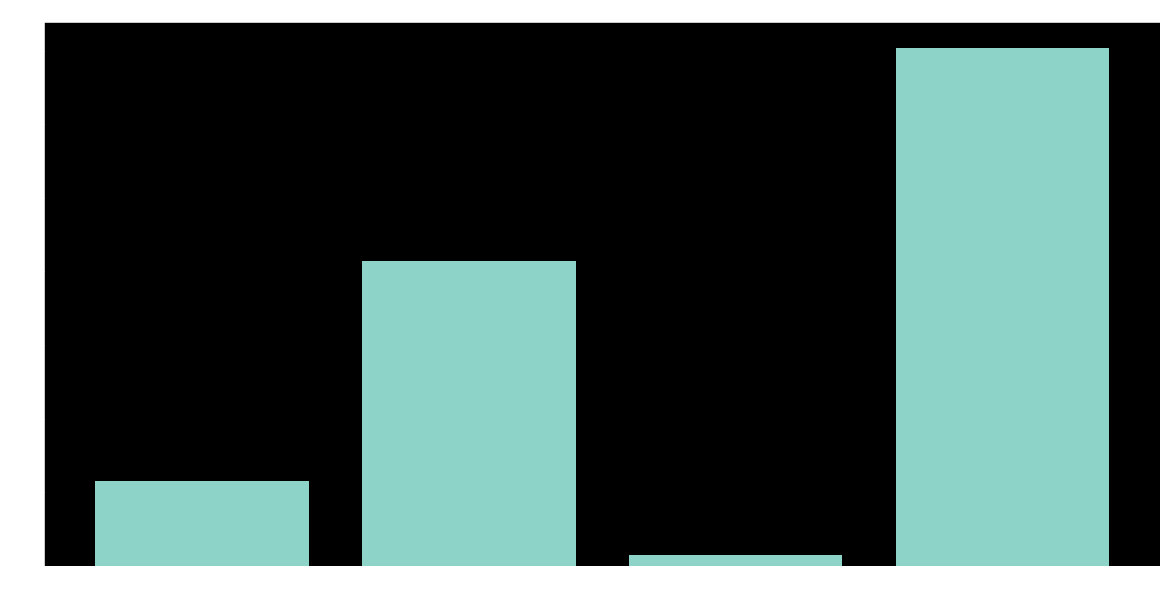

In [17]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(hourly.index.values, hourly["counts"])
ax.set_title('Pixels placed based on time of the day [UTC]')
ax.set_xlabel('hour of the day')
ax.set_ylabel('pixels placed')
fig.savefig('./plots/hourly_activity.pdf')

#### Activity based the day
How many **pixels** were **placed** based on the **day**.

In [18]:
daily = df["timestamp"].dt.strftime('%m-%d')
daily = daily.value_counts().rename_axis("day").to_frame("counts").sort_index()
daily

,counts
day,
04-03,3591961
04-04,2645074


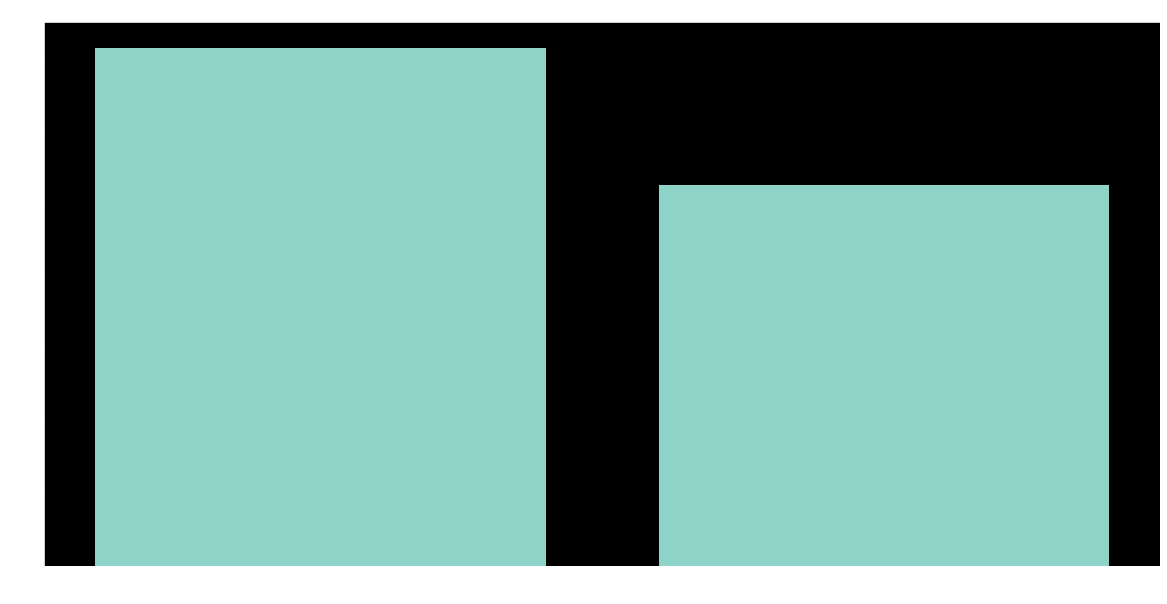

In [19]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(daily.index.values, daily["counts"])
ax.set_title('Pixels placed based on the day')
ax.set_xlabel('date')
ax.set_ylabel('pixels placed')
fig.savefig('./plots/daily_activity.pdf')